In [1]:
import tensorflow as tf
from tensorflow import keras
import IPython

# !pip install -q -U keras-tuner
import keras_tuner as kt

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dropout, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn import metrics 
print(tf.__version__)
print(keras.__version__)

2.5.0
2.5.0


# fit model 함수

In [2]:
def fit_model(seed_num):
    tf.random.set_seed(seed_num)
    lstm = Sequential()
    lstm.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))
    lstm.add(LSTM(units=128, activation='hard_sigmoid', return_sequences=True))
    lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
    lstm.add(Dropout(0.2))
    lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
    lstm.add(LSTM(units=32, activation='hard_sigmoid'))
    lstm.add(Dropout(0.2))
    lstm.add(Dense(units=1, activation='sigmoid'))
    #fit
    ep = 500
    pa = 30
#     lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, verbose=1)
    early_stop = EarlyStopping(monitor='val_acc', patience=30, verbose=1, restore_best_weights=True)
    optimizer = keras.optimizers.Adam(learning_rate = 0.001, decay=0.001)
    lstm.compile(optimizer= optimizer, loss = "binary_crossentropy", metrics=['acc'])
    history = lstm.fit(X_train, y_train, validation_split=0.25, batch_size=128, epochs=ep,  callbacks=[early_stop], shuffle=False)

    preds = lstm.predict(X_test)
    return preds

In [10]:
%%time
import random

seed_num = 48

random.seed(123)

x = np.load('/project/LSH/x_(7727,10,4069).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

CPU times: user 142 ms, sys: 746 ms, total: 888 ms
Wall time: 888 ms


# LSTM

In [11]:
tf.random.set_seed(seed_num)
lstm = Sequential()
lstm.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))
lstm.add(LSTM(units=128, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(units=64, activation='hard_sigmoid', return_sequences=True))
lstm.add(LSTM(units=32, activation='hard_sigmoid'))
lstm.add(Dropout(0.2))
lstm.add(Dense(units=1, activation='sigmoid'))
#fit
ep = 500
pa = 30
optimizer = keras.optimizers.Adam(learning_rate = 0.001, decay=0.001)
lstm.compile(optimizer= optimizer, loss = "binary_crossentropy", metrics=['acc'])

early_stop = EarlyStopping(monitor='val_acc', patience=30, verbose=1, restore_best_weights=True)
tb = tf.keras.callbacks.TensorBoard(log_dir='./logs')
MODEL_SAVE_FOLDER_PATH = './models/'
filepath = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_acc:.4f}.hdf5'
ckpt = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', save_best_only=True, save_weights_only=False, save_freq='epoch')

history = lstm.fit(X_train, y_train, validation_split=0.25, batch_size=128, epochs=ep,  callbacks=[early_stop, tb, ckpt], shuffle=False)

preds = lstm.predict(X_test)

Epoch 1/500
37/37 [==============================] - 7s 95ms/step - loss: 0.6763 - acc: 0.6059 - val_loss: 0.6677 - val_acc: 0.6151
Epoch 2/500
37/37 [==============================] - 2s 61ms/step - loss: 0.6723 - acc: 0.6091 - val_loss: 0.6632 - val_acc: 0.6151
Epoch 3/500
37/37 [==============================] - 2s 59ms/step - loss: 0.6377 - acc: 0.6270 - val_loss: 0.5795 - val_acc: 0.7193
Epoch 4/500
37/37 [==============================] - 2s 59ms/step - loss: 0.5020 - acc: 0.7668 - val_loss: 0.5148 - val_acc: 0.7529
Epoch 5/500
37/37 [==============================] - 2s 61ms/step - loss: 0.4168 - acc: 0.8223 - val_loss: 0.5173 - val_acc: 0.7594
Epoch 6/500
37/37 [==============================] - 2s 59ms/step - loss: 0.3652 - acc: 0.8563 - val_loss: 0.5442 - val_acc: 0.7510
Epoch 7/500
37/37 [==============================] - 2s 60ms/step - loss: 0.3277 - acc: 0.8710 - val_loss: 0.5699 - val_acc: 0.7439
Epoch 8/500
37/37 [==============================] - 2s 60ms/step - loss: 0.

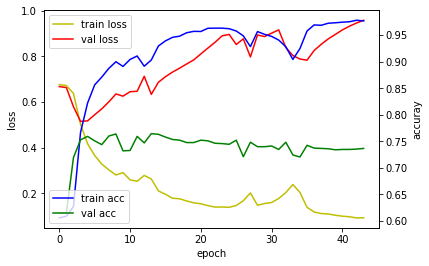

In [12]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [13]:
pred = lstm.predict(X_test)
pred[pred>0.5]=1
pred[pred<=0.5]=0
acc = metrics.accuracy_score(y_test, pred)
print(f'정확도 :{metrics.accuracy_score(y_test, pred)}, seed_num = {seed_num}')

정확도 :0.7650485436893204, seed_num = 48


In [6]:
%load_ext tensorboard 

In [10]:
%tensorboard --logdir './logs' --host=0.0.0.0 --port 6010

# reload saved model

In [14]:
# reload_model = tf.keras.models.load_model('/project/guri/Restart/models/05-0.7658.hdf5')
reload_model = tf.keras.models.load_model('/project/guri/Restart/models/14-0.7646.hdf5')

# ck = tf.train.get_checkpoint_state("test.ckpt")
# ck.model_checkpoint_path

In [15]:
for seed in range(0, 50):
    random.seed(seed)

    x = np.load('/project/LSH/x_(7727,10,4069).npy')
    y = np.load('/project/LSH/y_(7727,1).npy')

    idx = list(range(len(x)))
    random.shuffle(idx)

    i = round(x.shape[0]*0.8)
    X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
    X_test, y_test = x[idx[i:],:,:], y[idx[i:]]
    
    pred = reload_model.predict(X_test)
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    acc = metrics.accuracy_score(y_test, pred)
    print(f'정확도 :{metrics.accuracy_score(y_test, pred)}, seed_num = {seed}')

정확도 :0.858252427184466, seed_num = 0
정확도 :0.8699029126213592, seed_num = 1
정확도 :0.86084142394822, seed_num = 2
정확도 :0.8750809061488674, seed_num = 3
정확도 :0.858252427184466, seed_num = 4
정확도 :0.8692556634304207, seed_num = 5
정확도 :0.8472491909385114, seed_num = 6
정확도 :0.8537216828478964, seed_num = 7
정확도 :0.8563106796116505, seed_num = 8
정확도 :0.8601941747572815, seed_num = 9
정확도 :0.8647249190938512, seed_num = 10
정확도 :0.8809061488673139, seed_num = 11
정확도 :0.8453074433656957, seed_num = 12
정확도 :0.8640776699029126, seed_num = 13
정확도 :0.8763754045307444, seed_num = 14
정확도 :0.8770226537216829, seed_num = 15
정확도 :0.8699029126213592, seed_num = 16
정확도 :0.8530744336569579, seed_num = 17
정확도 :0.8576051779935275, seed_num = 18
정확도 :0.8640776699029126, seed_num = 19
정확도 :0.8686084142394822, seed_num = 20
정확도 :0.855663430420712, seed_num = 21
정확도 :0.8660194174757282, seed_num = 22
정확도 :0.8724919093851132, seed_num = 23
정확도 :0.8634304207119741, seed_num = 24
정확도 :0.8750809061488674, seed_num = 25
정

# 이어서 학습

In [16]:
# 이어서 학습
# hist = reload_model.fit(X_train, y_train, initial_epoch=5, epochs=20, validation_split=0.25, batch_size=128)
hist = reload_model.fit(X_train, y_train, initial_epoch=14, epochs=20, validation_split=0.25, batch_size=128)

Epoch 15/20
37/37 [==============================] - 5s 82ms/step - loss: 0.3677 - acc: 0.8611 - val_loss: 0.3979 - val_acc: 0.8422
Epoch 16/20
37/37 [==============================] - 2s 58ms/step - loss: 0.3309 - acc: 0.8807 - val_loss: 0.3967 - val_acc: 0.8435
Epoch 17/20
37/37 [==============================] - 2s 60ms/step - loss: 0.3150 - acc: 0.8859 - val_loss: 0.4016 - val_acc: 0.8402
Epoch 18/20
37/37 [==============================] - 2s 58ms/step - loss: 0.2991 - acc: 0.8960 - val_loss: 0.4067 - val_acc: 0.8428
Epoch 19/20
37/37 [==============================] - 2s 59ms/step - loss: 0.2770 - acc: 0.9101 - val_loss: 0.4129 - val_acc: 0.8389
Epoch 20/20
37/37 [==============================] - 2s 60ms/step - loss: 0.2660 - acc: 0.9122 - val_loss: 0.4519 - val_acc: 0.8273


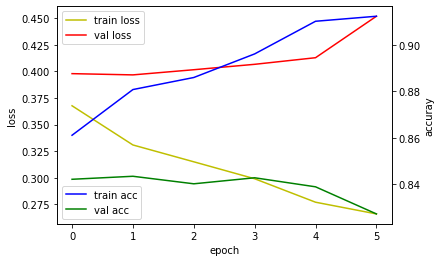

In [17]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [18]:
for seed in range(0, 50):
    random.seed(seed)

    x = np.load('/project/LSH/x_(7727,10,4069).npy')
    y = np.load('/project/LSH/y_(7727,1).npy')

    idx = list(range(len(x)))
    random.shuffle(idx)

    i = round(x.shape[0]*0.8)
    X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
    X_test, y_test = x[idx[i:],:,:], y[idx[i:]]
    
    pred = reload_model.predict(X_test)
    pred[pred>0.5]=1
    pred[pred<=0.5]=0
    acc = metrics.accuracy_score(y_test, pred)
    print(f'정확도 :{metrics.accuracy_score(y_test, pred)}, seed_num = {seed}')

정확도 :0.8841423948220065, seed_num = 0
정확도 :0.8919093851132686, seed_num = 1
정확도 :0.8789644012944984, seed_num = 2
정확도 :0.8925566343042072, seed_num = 3
정확도 :0.8802588996763754, seed_num = 4
정확도 :0.8944983818770227, seed_num = 5
정확도 :0.8789644012944984, seed_num = 6
정확도 :0.8763754045307444, seed_num = 7
정확도 :0.8770226537216829, seed_num = 8
정확도 :0.889967637540453, seed_num = 9
정확도 :0.8880258899676375, seed_num = 10
정확도 :0.9035598705501618, seed_num = 11
정확도 :0.8770226537216829, seed_num = 12
정확도 :0.8957928802588997, seed_num = 13
정확도 :0.8912621359223301, seed_num = 14
정확도 :0.8970873786407767, seed_num = 15
정확도 :0.8964401294498382, seed_num = 16
정확도 :0.8763754045307444, seed_num = 17
정확도 :0.8854368932038835, seed_num = 18
정확도 :0.8919093851132686, seed_num = 19
정확도 :0.8983818770226537, seed_num = 20
정확도 :0.8867313915857605, seed_num = 21
정확도 :0.8925566343042072, seed_num = 22
정확도 :0.8970873786407767, seed_num = 23
정확도 :0.8880258899676375, seed_num = 24
정확도 :0.8983818770226537, seed_num = 

In [19]:
reload_model.predict(X_test)

array([[0.9643559 ],
       [0.06516704],
       [0.9713927 ],
       ...,
       [0.97729343],
       [0.96409714],
       [0.5975809 ]], dtype=float32)

In [20]:
y_test

array([1, 0, 1, ..., 1, 1, 0])